<a href="https://colab.research.google.com/github/benihime91/retinanet_pet_detector/blob/master/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [1]:
# what GPU do we have ?
!nvidia-smi

Mon Sep 21 04:22:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Setup Google-Colab:**

In [3]:
# install dependencies
!pip install pytorch-lightning omegaconf --quiet
!pip install git+https://github.com/albumentations-team/albumentations --quiet

     |████████████████████████████████| 409kB 8.4MB/s 
     |████████████████████████████████| 276kB 14.4MB/s 
     |████████████████████████████████| 2.8MB 25.7MB/s 
     |████████████████████████████████| 829kB 61.3MB/s 
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.2.0 which is incompatible.
     |████████████████████████████████| 952kB 9.8MB/s 


In [ ]:
# Run this cell to mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [4]:
# clone the github repo:
!git clone --recurse-submodules -j8 https://github.com/benihime91/retinanet_pet_detector.git

Cloning into 'retinanet_pet_detector'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 857 (delta 95), reused 48 (delta 20), pack-reused 693
Receiving objects: 100% (857/857), 46.34 MiB | 11.24 MiB/s, done.
Resolving deltas: 100% (497/497), done.
Submodule 'pytorch_retinanet' (https://github.com/benihime91/pytorch_retinanet.git) registered for path 'pytorch_retinanet'
Cloning into '/content/retinanet_pet_detector/pytorch_retinanet'...
remote: Enumerating objects: 12, done.        
remote: Counting objects: 100% (12/12), done.        
remote: Compressing objects: 100% (7/7), done.        
remote: Total 1742 (delta 5), reused 11 (delta 5), pack-reused 1730        
Receiving objects: 100% (1742/1742), 55.13 MiB | 20.54 MiB/s, done.
Resolving deltas: 100% (1169/1169), done.
Submodule path 'pytorch_retinanet': checked out '00b3f8e389ba1803c1fe4a37ecde50c02510317c'


**Untar the data from Google Drive and save it to VM memory :**

- The cell below unzips the data assuming the `The Oxford-IIIT Pet Dataset` is present in `/content/drive/My Drive/Data/oxford-iiit-pet.tgz.`

- If data is not downloaded download the data from [here](https://www.robots.ox.ac.uk/~vgg/data/pets) and save in it in Google Drive under `/Data/oxford-iiit-pet.tgz`.

In [5]:
# unpacks the data
!tar xf /content/drive/My\ Drive/Data/oxford-iiit-pet.tgz -C /content/

**Imports:**

In [6]:
import sys
import os
import warnings

os.chdir("/content/retinanet_pet_detector")
warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext tensorboard

In [7]:
# Standard Imports
import numpy as np
from omegaconf import OmegaConf, DictConfig
import pandas as pd
import argparse
from PIL import Image


from references.data_utils import _get_logger
from references import Visualizer
from references.utils import get_label_dict
from train import main

from google.colab import files

# Set up logging
logger = _get_logger()
pd.set_option("display.max_colwidth",None)

**Preprare Data:**

Before training we need to convert the data into a format that is compatible with the `training pipeline.` We will use `references/data_utils.py` to convert all the xml annotation files into a csv that stores all the annotations and path to the Images.

The resutant csv file will be saved as `/{ouptut_dir}/data-full.csv`.

In [8]:
# Convert xml files to a csv file
!python references/data_utils.py \
    --action create \
    --img_dir "/content/oxford-iiit-pet/images" \
    --annot_dir "/content/oxford-iiit-pet/annotations/xmls" \
    --labels "/content/retinanet_pet_detector/data/labels.names" \
    --output_dir "/content/retinanet_pet_detector/data/"

[09/21 04:24:00 data_utils]: Converting xml files to a csv file
[09/21 04:24:00 data_utils]: Image Directory: /content/oxford-iiit-pet/images
[09/21 04:24:00 data_utils]: Annotation Directory: /content/oxford-iiit-pet/annotations/xmls
[09/21 04:24:00 data_utils]: Path to labels: /content/retinanet_pet_detector/data/labels.names
[09/21 04:24:00 data_utils]: Number of unique classes found: 37
[09/21 04:24:00 data_utils]: csv file saved as /content/retinanet_pet_detector/data/data-full.csv


This is what our data looks like:

In [9]:
df = pd.read_csv("/content/retinanet_pet_detector/data/data-full.csv")
df.head(5)

,filename,width,height,xmin,ymin,xmax,ymax,classes,labels
0,/content/oxford-iiit-pet/images/german_shorthaired_125.jpg,500,375,157,56,264,116,german_shorthaired,14
1,/content/oxford-iiit-pet/images/german_shorthaired_128.jpg,453,500,248,39,388,158,german_shorthaired,14
2,/content/oxford-iiit-pet/images/english_setter_178.jpg,365,500,19,13,275,270,english_setter,13
3,/content/oxford-iiit-pet/images/leonberger_107.jpg,333,500,92,145,193,248,leonberger,19
4,/content/oxford-iiit-pet/images/saint_bernard_165.jpg,500,375,164,76,362,232,saint_bernard,28


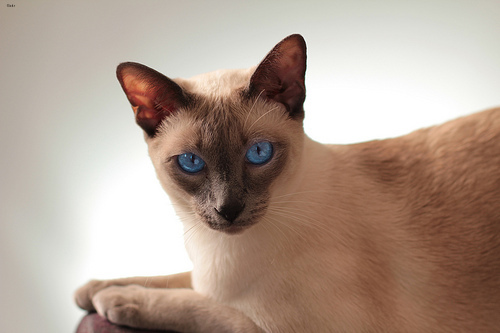

In [11]:
# sanity-check
Image.open(df.filename[100])

We will again the run the script used above but this time we will run this script to create `training`, `validation` & `test` sets from the full dataset.

In [13]:
# Create train, validaiton and test splits in the data
!python references/data_utils.py \
    --action split \
    --csv "/content/retinanet_pet_detector/data/data-full.csv"\
    --valid_size 0.3 \
    --test_size 0.5 \
    --output_dir "/content/retinanet_pet_detector/data/" \
    --seed 123

[09/21 04:24:45 data_utils]: path to the given csv file : /content/retinanet_pet_detector/data/data-full.csv
[09/21 04:24:45 data_utils]: Creating train, validation and test splits
[09/21 04:24:45 data_utils]: Number of training examples=2580
[09/21 04:24:45 data_utils]: Number of validation examples=553
[09/21 04:24:45 data_utils]: Number of test examples=553
[09/21 04:24:45 data_utils]: Files saved to /content/retinanet_pet_detector/data/


We can see that now we have 3 extra files train.csv, valid.csv & test.csv. This files correspond to the `train`,`validation` & `test` datasets respectively.

In [14]:
! ls "/content/retinanet_pet_detector/data"

data-full.csv  labels.names  test.csv  train.csv  valid.csv


In [15]:
# Read in the train and test dataframes
trn_df = pd.read_csv("/content/retinanet_pet_detector/data/train.csv")
tst_df = pd.read_csv("/content/retinanet_pet_detector/data/test.csv")
val_df = pd.read_csv("/content/retinanet_pet_detector/data/valid.csv")

In [16]:
trn_df.head()

,filename,width,height,xmin,ymin,xmax,ymax,classes,labels
0,/content/oxford-iiit-pet/images/german_shorthaired_125.jpg,500,375,157,56,264,116,german_shorthaired,14
1,/content/oxford-iiit-pet/images/german_shorthaired_128.jpg,453,500,248,39,388,158,german_shorthaired,14
2,/content/oxford-iiit-pet/images/english_setter_178.jpg,365,500,19,13,275,270,english_setter,13
3,/content/oxford-iiit-pet/images/leonberger_107.jpg,333,500,92,145,193,248,leonberger,19
4,/content/oxford-iiit-pet/images/shiba_inu_189.jpg,375,500,139,20,336,242,shiba_inu,31


In [17]:
tst_df.head()

,filename,width,height,xmin,ymin,xmax,ymax,classes,labels
0,/content/oxford-iiit-pet/images/saint_bernard_165.jpg,500,375,164,76,362,232,saint_bernard,28
1,/content/oxford-iiit-pet/images/staffordshire_bull_terrier_114.jpg,500,375,197,103,380,246,staffordshire_bull_terrier,34
2,/content/oxford-iiit-pet/images/boxer_102.jpg,500,375,90,24,414,326,boxer,8
3,/content/oxford-iiit-pet/images/scottish_terrier_141.jpg,375,500,60,68,294,320,scottish_terrier,30
4,/content/oxford-iiit-pet/images/Russian_Blue_100.jpg,375,500,56,52,305,371,russian_blue,27


In [18]:
val_df.head()

,filename,width,height,xmin,ymin,xmax,ymax,classes,labels
0,/content/oxford-iiit-pet/images/Persian_137.jpg,500,375,206,1,354,130,persian,23
1,/content/oxford-iiit-pet/images/pug_182.jpg,176,300,31,28,175,134,pug,25
2,/content/oxford-iiit-pet/images/Sphynx_172.jpg,500,340,239,75,395,237,sphynx,33
3,/content/oxford-iiit-pet/images/american_bulldog_171.jpg,394,500,127,38,273,170,american_bulldog,1
4,/content/oxford-iiit-pet/images/Bombay_148.jpg,500,375,351,49,436,141,bombay,7


**View some images from the datasets:**

In [19]:
# Read in the Labes dictionary 
# and initializer the visualizer to view images with bboxes
label_dict = get_label_dict("/content/retinanet_pet_detector/data/labels.names")
vis = Visualizer(label_dict)

[09/21 04:25:23 references.display_preds]: visualizer initialized


In [20]:
# These are the label
label_dict

{0: 'abyssinian',
 1: 'american_bulldog',
 2: 'american_pit_bull_terrier',
 3: 'basset_hound',
 4: 'beagle',
 5: 'bengal',
 6: 'birman',
 7: 'bombay',
 8: 'boxer',
 9: 'british_shorthair',
 10: 'chihuahua',
 11: 'egyptian_mau',
 12: 'english_cocker_spaniel',
 13: 'english_setter',
 14: 'german_shorthaired',
 15: 'great_pyrenees',
 16: 'havanese',
 17: 'japanese_chin',
 18: 'keeshond',
 19: 'leonberger',
 20: 'maine_coon',
 21: 'miniature_pinscher',
 22: 'newfoundland',
 23: 'persian',
 24: 'pomeranian',
 25: 'pug',
 26: 'ragdoll',
 27: 'russian_blue',
 28: 'saint_bernard',
 29: 'samoyed',
 30: 'scottish_terrier',
 31: 'shiba_inu',
 32: 'siamese',
 33: 'sphynx',
 34: 'staffordshire_bull_terrier',
 35: 'wheaten_terrier',
 36: 'yorkshire_terrier'}

In [21]:
np.random.seed(123)

def display_random_image(data):
    """
    Fn to display a random using the `Visualizer`
    from the given pandas dataframe. The bounding boxes are also
    drawn over the image.

    Args:
     data (`pd.dataframe`): A `pandas dataframe` where filename corresponds to 
                            the image path and bbox co-ordinates are stored in 
                            `[xmin,xmax,ymin,ymax]` & class_names (`int`) are 
                            stored in `[labels]`.
    """
    idx = np.random.randint(0, len(df))
    image_id = df.filename[idx]
    locs = df.loc[df.filename == image_id]
    boxes = locs[['xmin','ymin','xmax','ymax']].values
    labels = locs['labels'].values
    vis.draw_bboxes(image_id, boxes, labels)

[09/21 04:25:40 references.display_preds]: Found 1 bounding box(s) on the given image
[09/21 04:25:40 references.display_preds]: Displaying Results ....


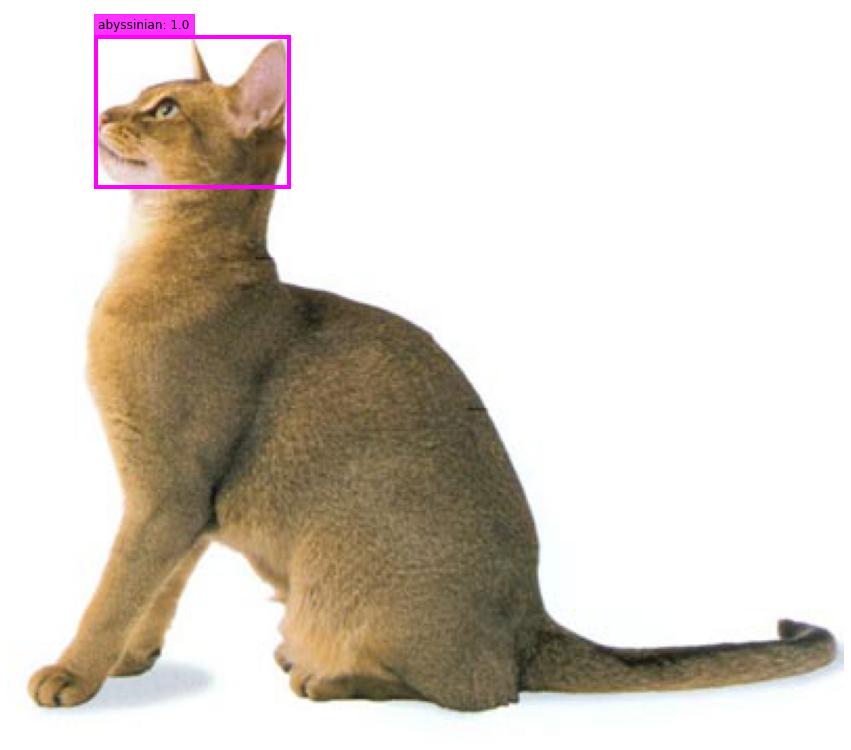

In [22]:
# Display a random Image from the Train dataset
display_random_image(data=trn_df)

[09/21 04:25:43 references.display_preds]: Found 1 bounding box(s) on the given image
[09/21 04:25:43 references.display_preds]: Displaying Results ....


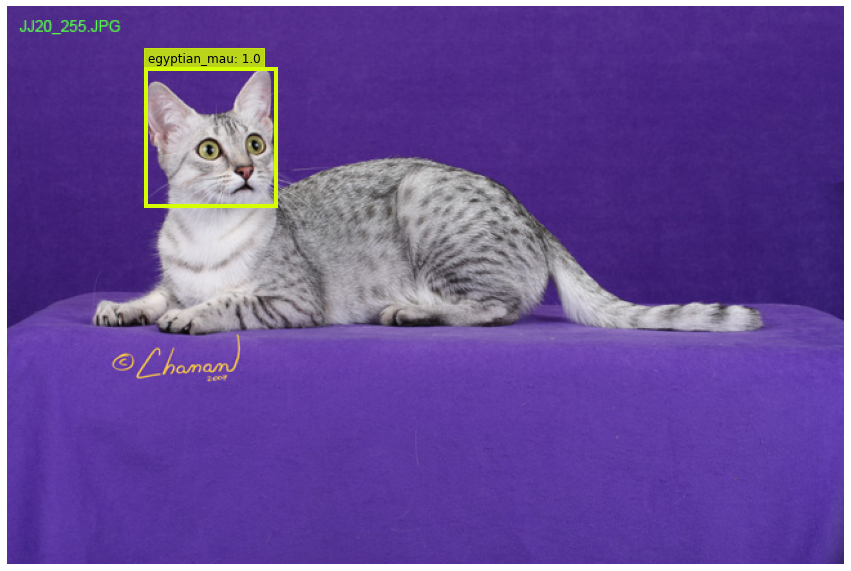

In [23]:
# Display a random Image from the test dataset
display_random_image(data=tst_df)

[09/21 04:25:43 references.display_preds]: Found 1 bounding box(s) on the given image
[09/21 04:25:43 references.display_preds]: Displaying Results ....


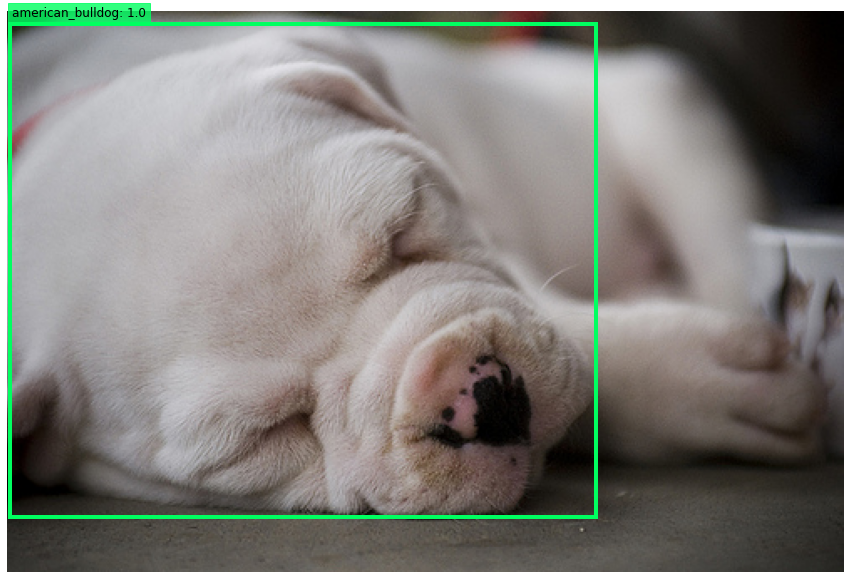

In [24]:
# Display a random Image from the validation dataset
display_random_image(data=val_df)

**Load (or Modify) the Config file:**

In [ ]:
# load the config file
config = OmegaConf.load("/content/retinanet_pet_detector/main.yaml")

# -------------------------------------------- #
# Modify some config parameters:
# -------------------------------------------- #

# since we will use the resnet50-backbone retinanet to train model
config.model.backbone_kind = "resnet50" 
# update the paths to the train, validation and test csv files
config.hparams.train_csv = "/content/retinanet_pet_detector/data/train.csv"
config.hparams.valid_csv = "/content/retinanet_pet_detector/data/valid.csv"
config.hparams.test_csv  = "/content/retinanet_pet_detector/data/test.csv"
# update the batch size for the train dataset
config.hparams.train_batch_size = 4
# path to where checkpoint and final weights are to saved
config.trainer.model_checkpoint.params.filepath = "/content/drive/My Drive/retianet-pets"
# path to where the training logs are to saved for TensorBoard Logger
config.trainer.logger.params.save_dir = "/content/logs/"
# modify scheduler parameters
config.hparams.scheduler.params.milestones = [52, 68]
# modify optimier
config.hparams.optimizer.params.lr = 0.001
config.hparams.optimizer.params.weight_decay = 1e-04
# epochs to train for
config.trainer.flags.max_epochs = 80

# Save the modified config file
OmegaConf.save(config=config, f="/content/retinanet_pet_detector/main.yaml")

In [ ]:
# Load and view the modified config file
config = OmegaConf.load("/content/retinanet_pet_detector/main.yaml")
logger.info(f"\nConfiguration File:  \n{OmegaConf.to_yaml(config)}")

### **Train, Validation & Test :**

In colab use the main function to train otherwise Lightning progress bar goes mad, this issue is highlighted [here]( https://github.com/PyTorchLightning/pytorch-lightning/issues/721). 

The `main` function accepts `argparse` arguments so we will first define a `Dictionary` with the args and convert it to `argparse.Namespace` instance

In [ ]:
# Creat argument dictionary
d = {"config": "/content/retinanet_pet_detector/main.yaml", "verbose": 0}
args = argparse.Namespace(**d)
logger.info(f"Namespace Arguments:  {args}")

**Start Train :**

In [ ]:
# run the main function
# set a seed number to ensure results are reproducible
main(args, seed=123)

**Tensorboard Logs:**

In [ ]:
%tensorboard --logdir "/content/logs/"

## **Inference with saved weights:**

To do inference we need to modify or create a config file for inference. The config file for inference should contain the following:
- `model_backbone` (`str`) : resnet backbone used for the retinanet model.
- `url` (`str`) : url or the path to where weights are saved.
- `num_classes` (`int`) : total number of unique classes.

We will save this `config` file at : `/content/retinanet_pet_detector/config/resnet50.yaml`

In [ ]:
# Since we used a resnet-50 backbone for our retinanet model
# we will load in the config for the resnet-34 model
# and update the url to be the trainerd weights.
backbone = "resnet50"
# path to where model weights are saved
url = "/content/drive/My Drive/retianet-pets/weights.pth"
# total number of classes
num_classes = 37

d = {"model_backbone": backbone, "url": url, "num_classes": num_classes}
conf = DictConfig(d)

# Save the config File
fname = "/content/retinanet_pet_detector/config/resnet50.yaml"
OmegaConf.save(config=conf, f=fname)


# Print out the config File
print(OmegaConf.to_yaml(conf))

In [ ]:
# path to the ocnfig file
config = "/content/retinanet_pet_detector/config/resnet50.yaml"

**Run Inference:**

In [ ]:
!python inference.py \
    --config {config} \
    --image {tst_df.filename[100]} \
    --score_thres 0.7 \
    --iou_thres 0.4 \
    --save_dir "/content/" \
    --fname "res_1.png" \

In [ ]:
Image.open("/content/res_1.png")

In [ ]:
!python inference.py \
    --config {config} \
    --image {tst_df.filename[800]} \
    --score_thres 0.7 \
    --iou_thres 0.4 \
    --save_dir "/content/" \
    --fname "res_2.png" \

In [ ]:
Image.open("/content/res_2.png")

**The following cells run inference on user uploaded image:**

In [ ]:
uploaded = files.upload()
fname = list(uploaded.keys())[0]

In [ ]:
!python inference.py \
    --config {config}\
    --image {fname} \
    --score_thres 0.7 \
    --iou_thres 0.4 \
    --save_dir "/content/" \
    --fname "res_3.png" \

In [ ]:
Image.open("/content/res_3.png")